#Sarcasm Detection: Using Transformers Encoder Block

In [ ]:
import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (15,6)
plt.rcParams['font.size'] = 18

Loading dataset

In [ ]:
df1=pd.read_json('/content/Sarcasm_Headlines_Dataset.json',lines=True)
df2=pd.read_json('/content/Sarcasm_Headlines_Dataset_v2.json',lines=True)


In [ ]:
print("Columns in df1:", df1.columns)
print("Columns in df2:", df2.columns)

Columns in df1: Index(['article_link', 'headline', 'is_sarcastic'], dtype='object')
Columns in df2: Index(['is_sarcastic', 'headline', 'article_link'], dtype='object')


In [ ]:
df1=df1[['headline','is_sarcastic']]
df2=df2[['headline','is_sarcastic']]
df=pd.concat([df1,df2])
df.reset_index(drop=True, inplace=True)

#Data Cleaning

In [ ]:
df.sample(5)

,headline,is_sarcastic
42851,"the eu, the grexit, and market failure",0
48519,1-800-eat-shit finally publishes decades of re...,1
55105,rapper not entirely sure who else is on this t...,1
36525,how netflix's 'girlboss' perpetuates negative ...,0
16976,watch 'harry potter' actors get sorted into ho...,0


In [ ]:
df.isnull().sum()

,0
headline,0
is_sarcastic,0


In [ ]:
df.duplicated().sum()

26825

In [ ]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows)

                                                headline  is_sarcastic
1091   antarctic observational comic running out of i...             1
2265                                      sunday roundup             0
2975   the best chance to defeat roy moore may be for...             0
3802                                      sunday roundup             0
4605                                      sunday roundup             0
...                                                  ...           ...
55323       jews to celebrate rosh hashasha or something             1
55324  internal affairs investigator disappointed con...             1
55325  the most beautiful acceptance speech this week...             0
55326  mars probe destroyed by orbiting spielberg-gat...             1
55327                 dad clarifies this not a food stop             1

[26825 rows x 2 columns]


In [ ]:
df.drop_duplicates(inplace=True)

#Exploratory data analysis

<Axes: xlabel='is_sarcastic', ylabel='count'>

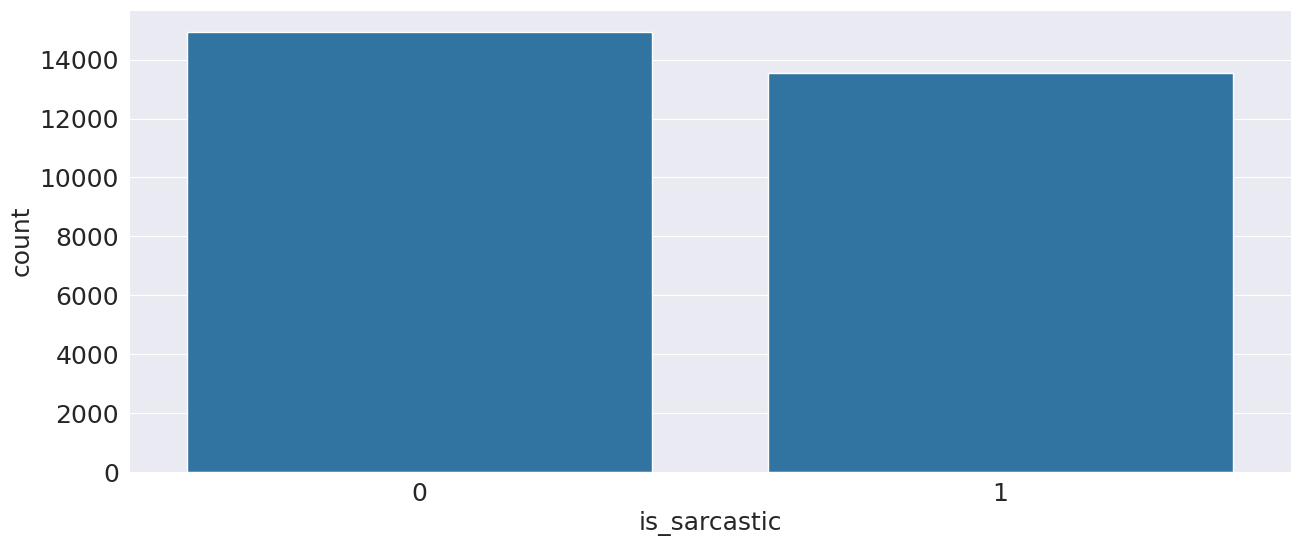

In [ ]:
sns.countplot(data=df,x='is_sarcastic')

#Preprocessing

In [ ]:
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))
stop_words.remove('not')
lemm = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
def text_cleaning(x):

    headline = re.sub('\s+\n+', ' ', x)
    headline = re.sub('[^a-zA-Z0-9]', ' ', x)
    headline = headline.lower()
    headline = headline.split()

    headline = [lemm.lemmatize(word, "v") for word in headline if not word in stop_words]
    headline = ' '.join(headline)

    return headline

In [ ]:
df['headline'] = df['headline'].apply(text_cleaning)

In [ ]:
import spacy
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
def get_entities(x):
    entity = []
    text = spacy_eng(x)
    for word in text.ents:
        entity.append(word.label_)
    return ",".join(entity)

df['entity'] = df['headline'].apply(get_entities)

In [ ]:
df.sample(5)

,headline,is_sarcastic,entity
15706,drink love work beyonce may get trouble,0,
14818,report election day americans time 2016 room p...,1,"DATE,NORP,DATE"
13328,friend send link 8 minute youtube video must f...,1,TIME
14203,adorable cotton candy girl hero need right,0,
1970,indian casino one saddest place earth,1,"NORP,CARDINAL"


#Train_Test_split

In [ ]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['headline'], df['is_sarcastic'], test_size=0.2, random_state=42)

#Tokenization

In [ ]:
import tensorflow as tf
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=5000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train)
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_train_pad = tf.keras.preprocessing.sequence.pad_sequences(x_train_seq, padding='post',maxlen=maxlen)
x_test_pad = tf.keras.preprocessing.sequence.pad_sequences(x_test_seq, padding='post',maxlen=maxlen)

#Multi Head Attention

In [ ]:
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers
from tensorflow.keras.layers import Embedding, Layer, Dense, Dropout, MultiHeadAttention, LayerNormalization, Input, GlobalAveragePooling1D
from tensorflow.keras.layers import LSTM, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

In [ ]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, heads, neurons):
        super(TransformerEncoder, self).__init__()
        self.att = layers.MultiHeadAttention(num_heads=heads, key_dim=embed_dim)
        self.ffn = Sequential(
            [layers.Dense(neurons, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(0.5)
        self.dropout2 = layers.Dropout(0.5)

    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

#Model Definition

In [ ]:
embed_dim = 50
heads = 2
neurons = 32
maxlen = 20
vocab_size = 20886

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerEncoder(embed_dim, heads, neurons)
x = transformer_block(x, training=True)
x = layers.GlobalAveragePooling1D()(x)
x = Dropout(0.35)(x)
outputs = layers.Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=outputs)

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.0003), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ token_and_position_embedding_1       │ (None, 20, 50)              │       1,045,300 │
│ (TokenAndPositionEmbedding)          │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ transformer_encoder_1                │ (None, 20, 50)              │          23,832 │
│ (TransformerEncoder)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 50)                  │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,069,183 (4.08 MB)

 Trainable params: 1,069,183 (4.08 MB)

 Non-trainable params: 0 (0.00 B)

#Model Training

In [ ]:
model_name = "model.keras"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0.001, patience = 1, verbose = 1)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = model.fit(x_train_pad,y_train,
                    epochs=25,
                    batch_size=32,
                    callbacks=[earlystopping])

Epoch 1/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.6192 - loss: 0.6457
Epoch 2/25
 14/713 ━━━━━━━━━━━━━━━━━━━━ 8s 12ms/step - accuracy: 0.8167 - loss: 0.3927

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8121 - loss: 0.4036
Epoch 3/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8551 - loss: 0.3297
Epoch 4/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.8762 - loss: 0.2938
Epoch 5/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.8913 - loss: 0.2586
Epoch 6/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 12ms/step - accuracy: 0.9098 - loss: 0.2229
Epoch 7/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - accuracy: 0.9194 - loss: 0.2045
Epoch 8/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s 14ms/step - accuracy: 0.9285 - loss: 0.1854
Epoch 9/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9332 - loss: 0.1755
Epoch 10/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 10s 13ms/step - accuracy: 0.9375 - loss: 0.1540
Epoch 11/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9434 - loss: 0.1391
Epoch 12/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.9456 - loss: 0.1312
Epoch 13/25
713/713 ━━━━━━━━━━━━━━━━━━━━ 11s

#Model Evaluation

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
y_pred = model.predict(x_test_pad)
y_pred[y_pred>=0.85] = 1
y_pred[y_pred<0.85] = 0

print(classification_report(y_test, y_pred))

179/179 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
              precision    recall  f1-score   support

           0       0.76      0.80      0.78      2991
           1       0.77      0.72      0.74      2710

    accuracy                           0.76      5701
   macro avg       0.76      0.76      0.76      5701
weighted avg       0.76      0.76      0.76      5701



<Axes: >

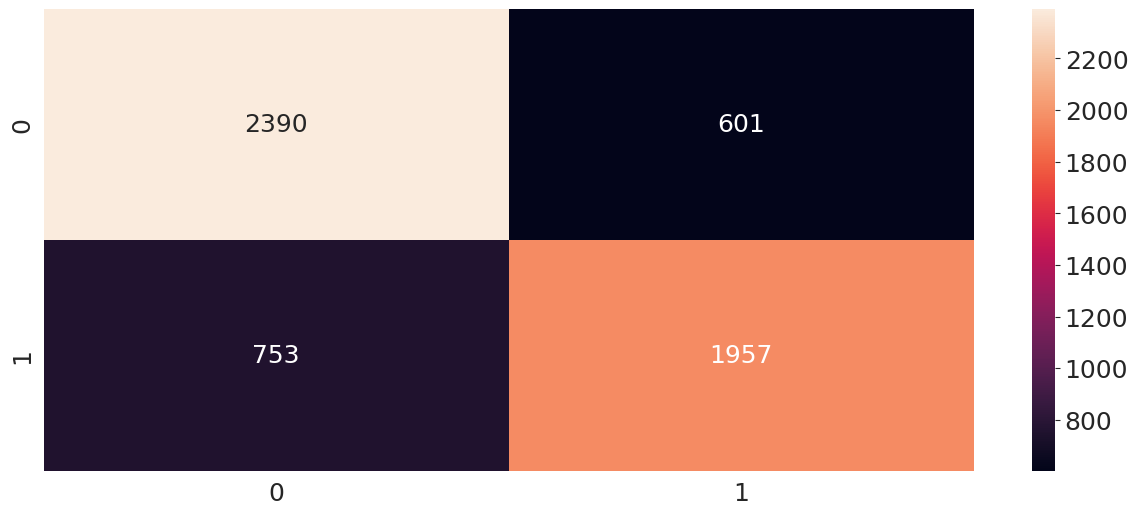

In [ ]:
sns.heatmap(confusion_matrix(y_test,y_pred),annot=True,fmt='.4g')